# Environment

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import os
import gc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [2]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/GSE171266'
os.chdir(wd_dir)


# Load raw data

In [3]:
# Load WT data (GSM5221533)
adata_wt = sc.read_10x_mtx(
    './DATA/GSM5221533_1',  
    var_names='gene_symbols',
    cache=True
)
adata_wt.var_names_make_unique()
adata_wt.obs['sample'] = 'WT_D686D'

# Load Mutant data (GSM5221534)
adata_mut = sc.read_10x_mtx(
    './DATA/GSM5221534_2',  
    var_names='gene_symbols',
    cache=True
)
adata_mut.var_names_make_unique()
adata_mut.obs['sample'] = 'Mut_D868N'

# Concatenate the datasets
adata = adata_wt.concatenate(adata_mut, join='outer')

... reading from cache file cache/DATA-GSM5221533_1-matrix.h5ad
... reading from cache file cache/DATA-GSM5221534_2-matrix.h5ad


/beegfs/scratch/tmp/ipykernel_53470/3713295076.py:20: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_wt.concatenate(adata_mut, join='outer')


In [4]:
gc.collect()

8

In [5]:
adata

AnnData object with n_obs × n_vars = 20384640 × 36601
    obs: 'sample', 'batch'
    var: 'gene_ids', 'feature_types'

In [6]:
# Save the data
adata.write_h5ad('./output/GSE171266.h5ad', compression='lzf')
gc.collect()


0

# Load h5ad data

In [7]:
# Load the data back
adata = sc.read_h5ad('./output/GSE171266.h5ad')
gc.collect()

12

# Filter data

In [8]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Filter cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
gc.collect()

filtered out 20226945 cells that have less than 200 genes expressed
filtered out 13049 genes that are detected in less than 3 cells


321

In [9]:
# Filter cells based on mitochondrial gene content
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20]
gc.collect()

0

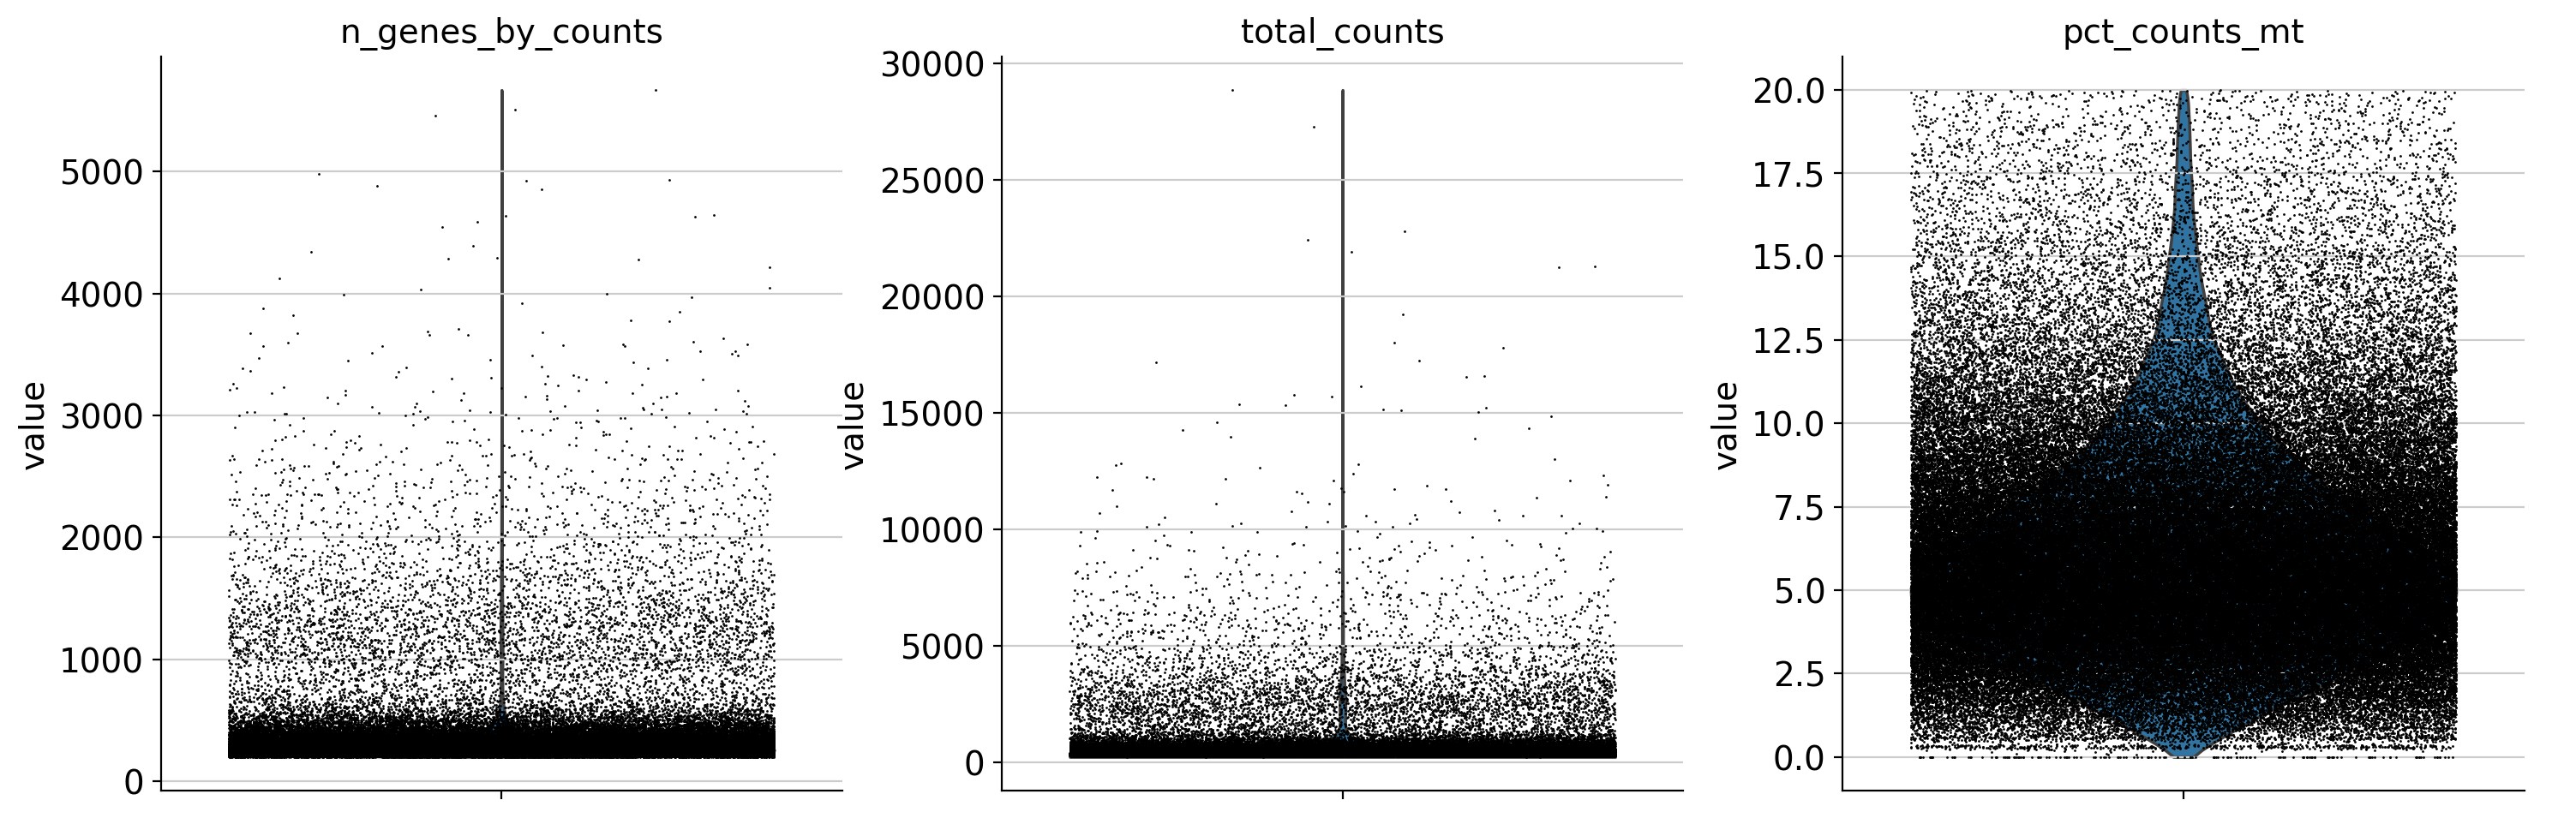

384

In [10]:
# Plot quality metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
gc.collect()

In [11]:
# Filter cells based on QC metrics (adjust these thresholds as needed)
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.total_counts < 10000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
gc.collect()

9454

In [12]:
adata

View of AnnData object with n_obs × n_vars = 154843 × 23552
    obs: 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'

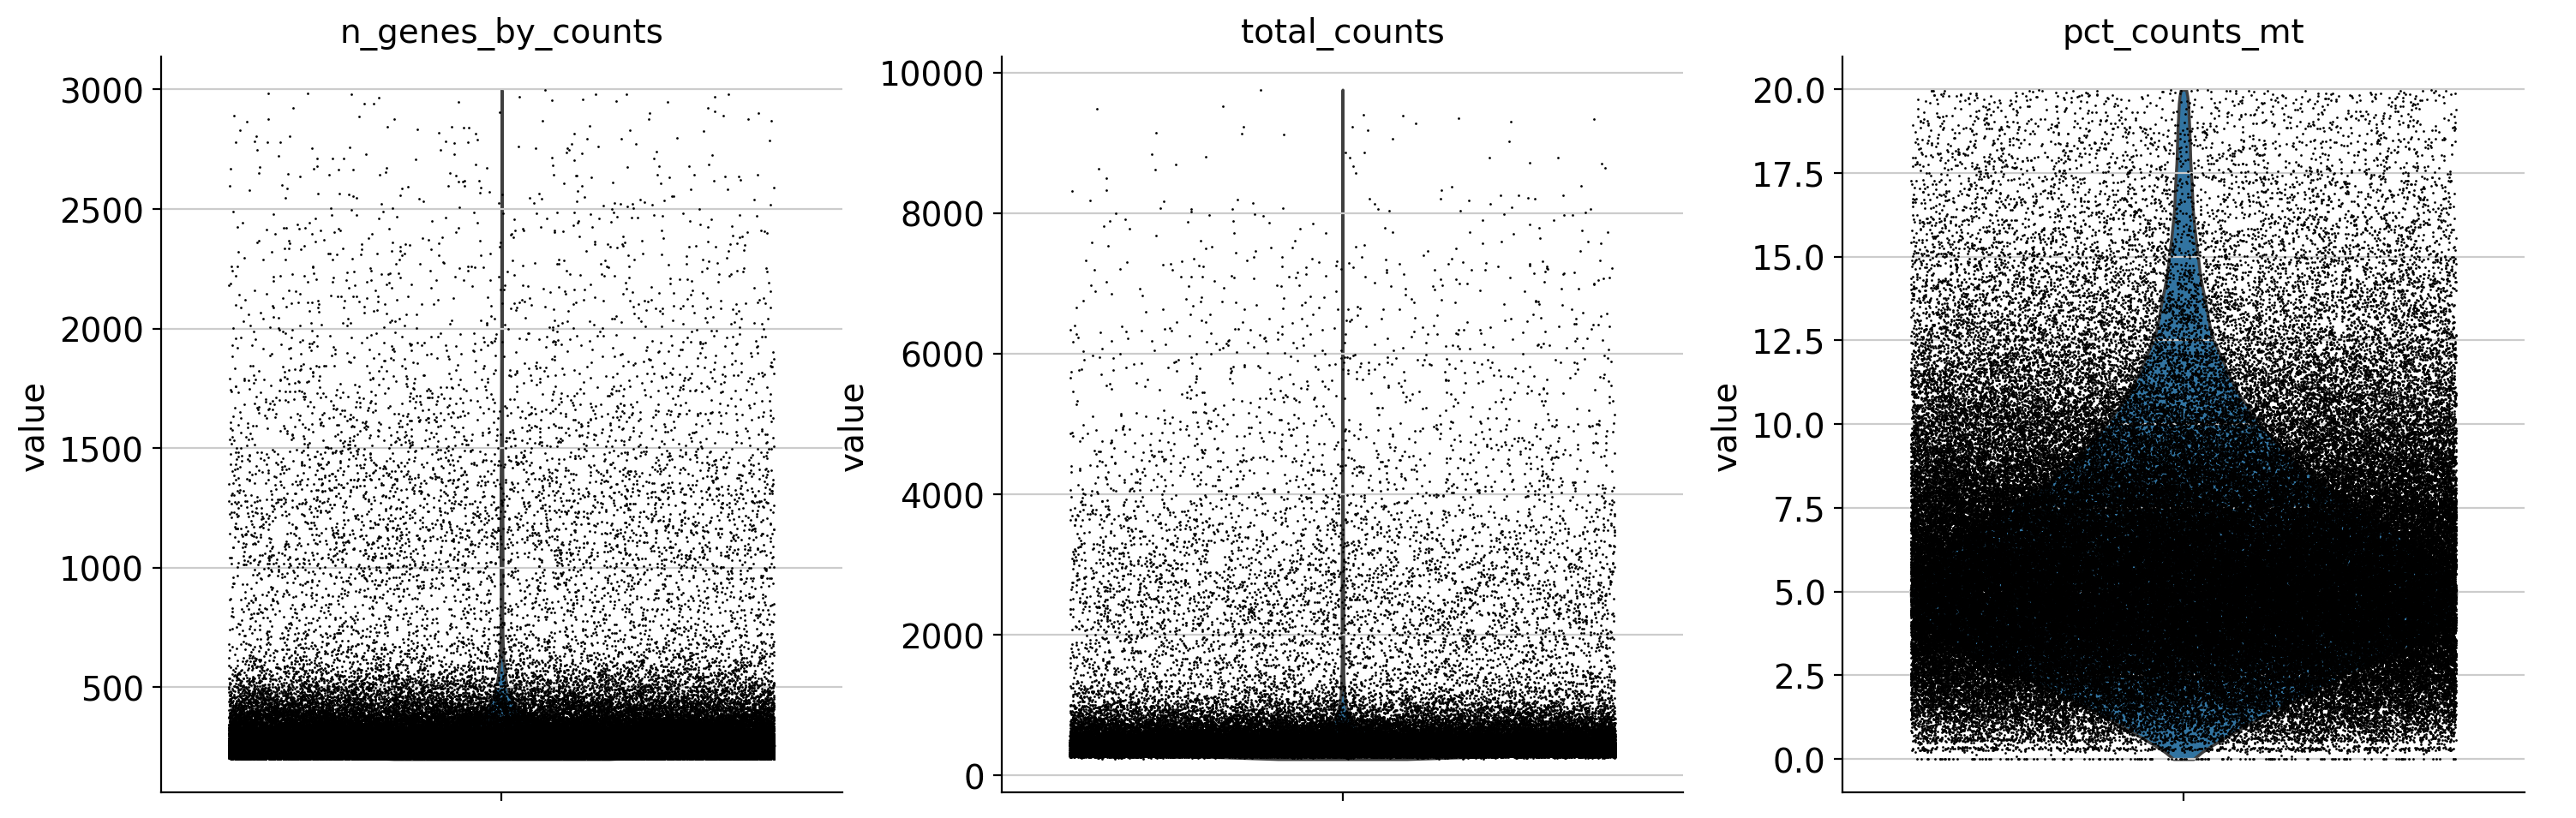

381

In [13]:
# Plot quality metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
gc.collect()

# Normalize the data

In [14]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
gc.collect()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


8630

In [15]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
gc.collect()

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


0

In [16]:
# Scale the data
sc.pp.scale(adata, max_value=10)
gc.collect()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


7

# Run PCA, compute neighborhood graph and UMAP

In [17]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')
gc.collect()

computing PCA
    with n_comps=50
    finished (0:00:24)


99

In [18]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
gc.collect()

# Run UMAP
sc.tl.umap(adata)
gc.collect()

# Perform clustering
# sc.tl.leiden(adata)
# gc.collect()

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:53)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:16)


22809

In [19]:
# Save the AnnData
adata.write_h5ad('./output/GSE171266_processed.h5ad')
gc.collect()

0

# Load processed data

In [20]:
# Load the saved AnnData object
adata_loaded = sc.read_h5ad('./output/GSE171266_processed.h5ad')
print(adata_loaded)
gc.collect()

AnnData object with n_obs × n_vars = 154843 × 1061
    obs: 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


11

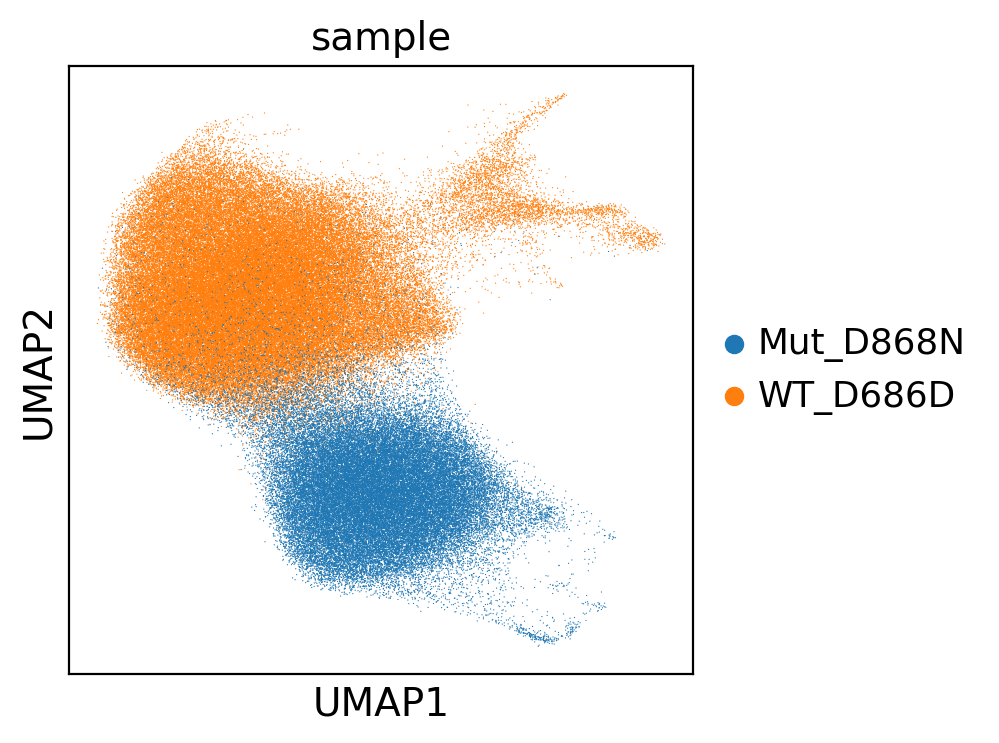

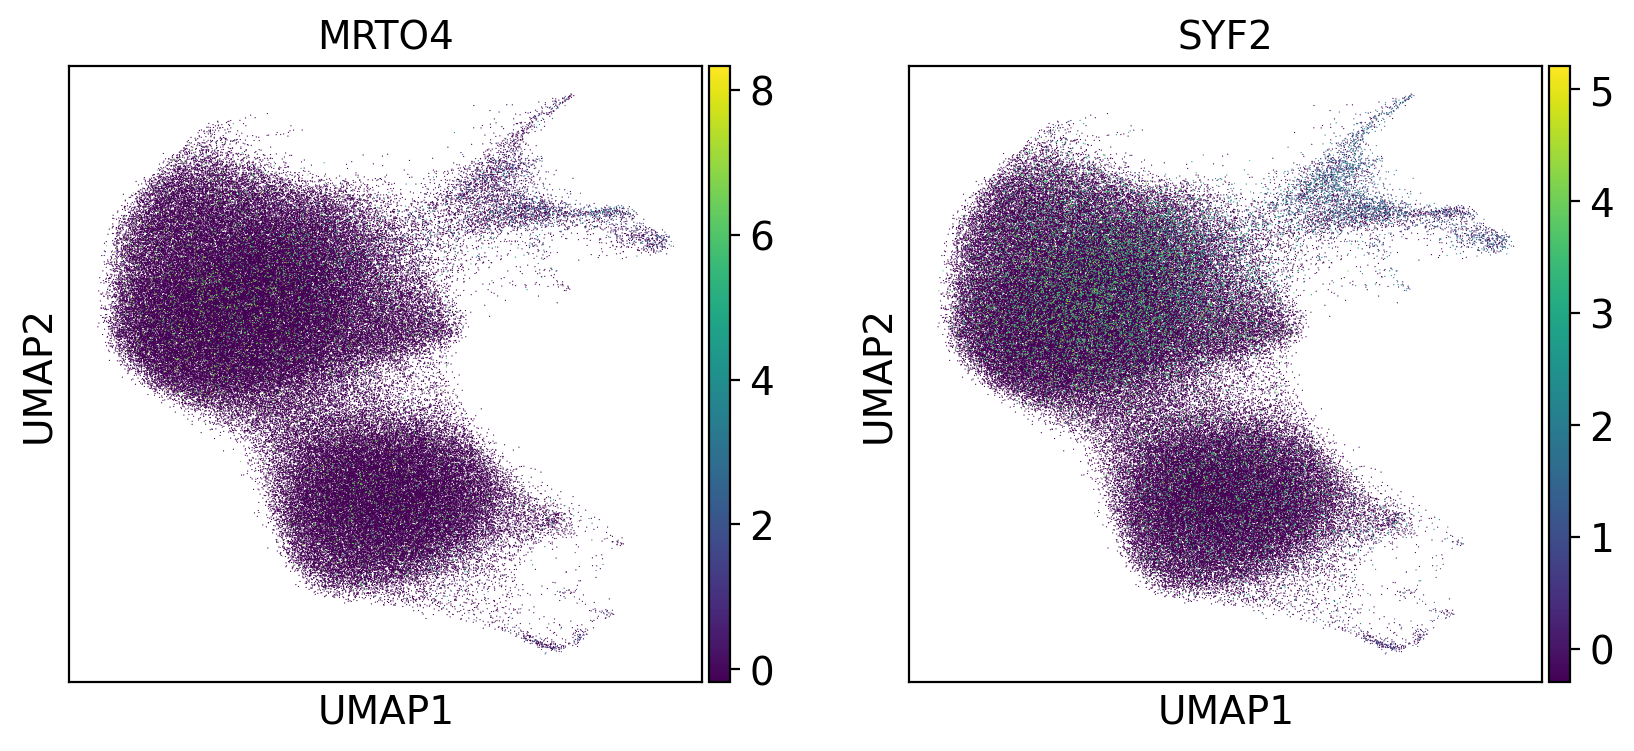

Available genes: ['MRPL20', 'HES5', 'ACOT7', 'MRTO4', 'CAMK2N1', 'ID3', 'SRRM1', 'SYF2', 'TRNP1', 'DNAJC8', 'ATP5IF1', 'SNHG12', 'ZCCHC17', 'CLSPN', 'CDCA8', 'PPIH', 'FAM183A', 'KIF2C', 'LURAP1', 'BEND5', 'ELAVL4', 'AL049637.2', 'CDKN2C', 'HSPB11', 'LRRC42', 'NFIA', 'USP1', 'ITGB3BP', 'GADD45A', 'FUBP1', 'IFI44L', 'RPF1', 'C1orf52', 'GTF2B', 'C1orf194', 'PSRC1', 'GSTM3', 'PIFO', 'DCLRE1B', 'NHLH2', 'TRIM45', 'HIST2H4B', 'HIST2H2AC', 'PLEKHO1', 'AL391069.2', 'S100A10', 'S100A11', 'S100A6', 'C1orf189', 'MEX3A', 'C1orf61', 'TSTD1', 'CFAP126', 'DUSP12', 'NUF2', 'CCDC181', 'MRPS14', 'BRINP2', 'RGS16', 'IVNS1ABP', 'HMCN1', 'C1orf53', 'LHX9', 'UBE2T', 'KLHDC8A', 'SERTAD4-AS1', 'LINC00467', 'CENPF', 'TAF1A', 'AL392172.1', 'NVL', 'CNIH4', 'ENAH', 'PARP1', 'C1orf35', 'MRPL55', 'GUK1', 'HIST3H2A', 'RNF187', 'RAB4A', 'CCSAP', 'PGBD5', 'C1orf131', 'TSNAX', 'COA6', 'TOMM20', 'ARID4B', 'GREM2', 'FH', 'EXO1', 'COX20', 'HNRNPU', 'SCCPDH', 'SNTG2', 'ADI1', 'SOX11', 'SILC1', 'ITGB1BP1', 'RRM2', 'FAM49A',

8244

In [21]:
# Plot UMAP
sc.pl.umap(adata, color=['sample']) # , 'leiden'
gc.collect()

# Plot gene expression
# Check if genes are present in the dataset before plotting
genes_to_plot = ['MRTO4', 'SYF2']
available_genes = [gene for gene in genes_to_plot if gene in adata.var_names]

if available_genes:
    sc.pl.umap(adata, color=available_genes)
else:
    print("None of the specified genes were found in the dataset.")

# If you want to see all available genes:
print("Available genes:", adata.var_names.tolist())

gc.collect()

# Find marker gene

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


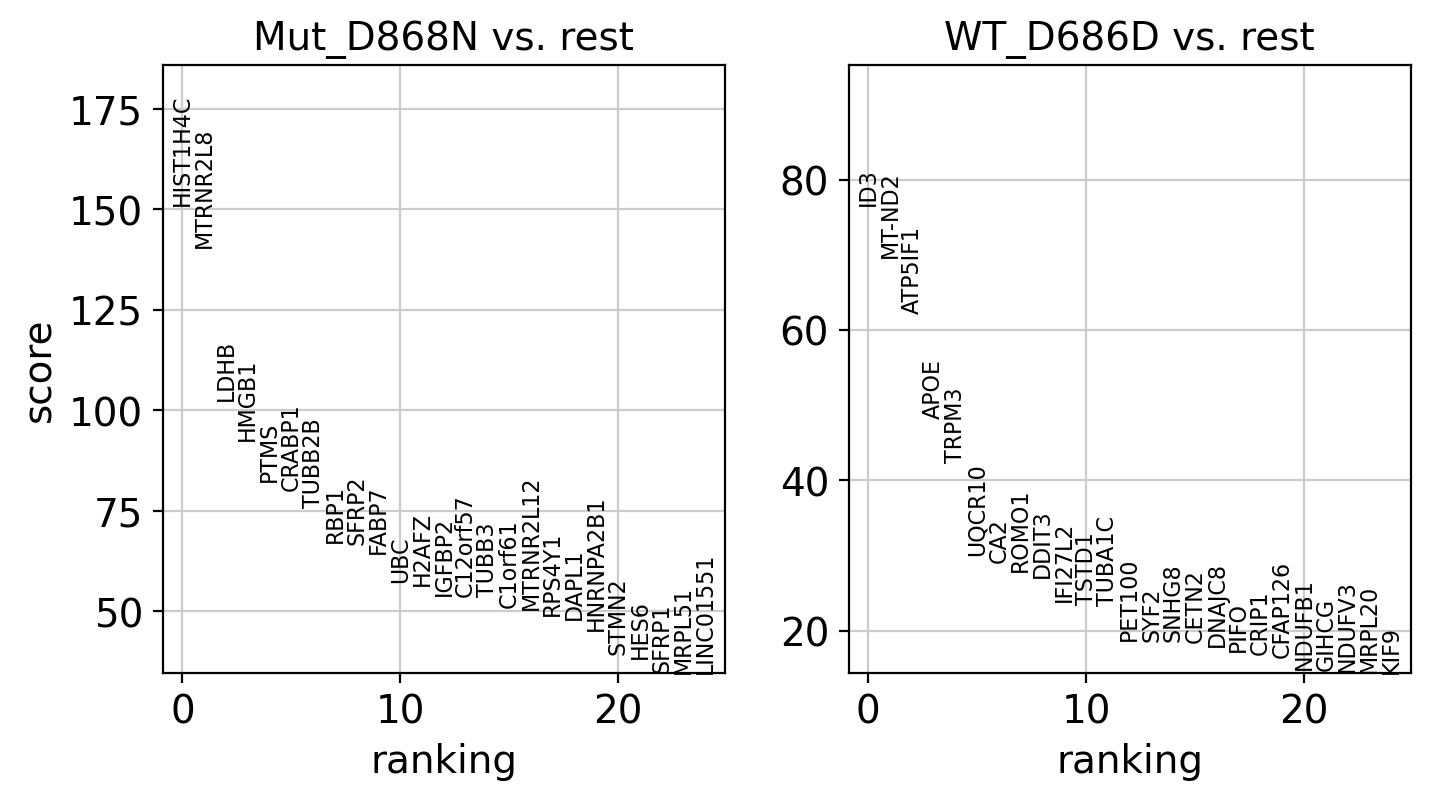

7655

In [22]:
# Find marker genes for each cluster
# sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# gc.collect()

# Find differentially expressed genes between WT and Mutant
sc.tl.rank_genes_groups(adata, 'sample', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
gc.collect()

In [23]:
# Save the AnnData
adata.write_h5ad('./output/GSE171266_processed.h5ad')
gc.collect()


0

# Load processed data 2

In [24]:
# Load the saved AnnData object
adata = sc.read_h5ad('./output/GSE171266_processed.h5ad')
gc.collect()

12

In [25]:
# # Save the processed AnnData object
# adata.write('GSE171266_processed.h5ad')

# # Save key figures
# sc.pl.umap(adata, color=['sample', 'leiden'], save='umap_sample_clusters.pdf')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save='marker_genes.pdf')

# Load bulk data

## Check data format

In [26]:
def examine_file_structure(filename):
    try:
        with gzip.open(filename, 'rt') as f:
            # Read the first few lines
            print(f"First 5 lines of {filename}:")
            for i, line in enumerate(f):
                if i < 5:
                    print(line.strip())
                else:
                    break
            
            # Move back to the start of the file
            f.seek(0)
            
            # Count total lines
            line_count = sum(1 for line in f)
            print(f"\nTotal number of lines: {line_count}")
            
            # Examine the structure of a non-comment line
            f.seek(0)
            next(f)  # Skip the comment line
            sample_line = next(f).strip().split('\t')
            print(f"\nNumber of columns: {len(sample_line)}")
            print("Column values:")
            for i, value in enumerate(sample_line):
                print(f"  Column {i+1}: {value}")
    
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error examining file {filename}: {str(e)}")

examine_file_structure('./DATA/GSM4559050_WT1Aligned.sortedByCoord.out_counts.txt.gz')

First 5 lines of ./DATA/GSM4559050_WT1Aligned.sortedByCoord.out_counts.txt.gz:
# Program:featureCounts v2.0.0; Command:"featureCounts" "-T" "10" "-p" "-t" "exon" "-g" "gene_id" "-a" "/media/l/3TB/Gencode/Human/gencode.v33.annotation.gff3" "-o" "/media/l/3TB/SETBP1_RNA/NPCs/WT1Aligned.sortedByCoord.out_counts.txt" "/media/l/3TB/SETBP1_RNA/NPCs/WT1Aligned.sortedByCoord.out.bam"
Geneid	Chr	Start	End	Strand	Length	/media/l/3TB/SETBP1_RNA/NPCs/WT1Aligned.sortedByCoord.out.bam
ENSG00000223972.5	chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1	11869;12010;12179;12613;12613;12975;13221;13221;13453	12227;12057;12227;12721;12697;13052;13374;14409;13670	+;+;+;+;+;+;+;+;+	1735	6
ENSG00000227232.5	chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1	14404;15005;15796;16607;16858;17233;17606;17915;18268;24738;29534	14501;15038;15947;16765;17055;17368;17742;18061;18366;24891;29570	-;-;-;-;-;-;-;-;-;-;-	1351	90
ENSG00000278267.1	chr1	17369	17436	-	68	7

Total number of lines: 60619

Number of columns: 7

## Load data

In [27]:
def load_bulk_data(filename):
    try:
        with gzip.open(filename, 'rt') as f:
            # Skip the first line (comment)
            next(f)
            # Read the header to get column names
            header = next(f).strip().split('\t')
            
            # Read the data, specifying column names
            df = pd.read_csv(f, sep='\t', header=None, names=header)
            
            # Convert 'Length' and count column to int
            count_column_name = header[-1]
            print(count_column_name)
            df['Length'] = df['Length'].astype(int)
            df[count_column_name] = df[count_column_name].astype(int)
            
            # Handle multiple chr, start, end, and strand entries
            df['Chr'] = df['Chr'].str.split(';')
            df['Start'] = df['Start'].str.split(';').apply(lambda x: [int(i) for i in x])
            df['End'] = df['End'].str.split(';').apply(lambda x: [int(i) for i in x])
            df['Strand'] = df['Strand'].str.split(';')
            
        return df.set_index('Geneid')[count_column_name]
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except Exception as e:
        print(f"Error loading file {filename}: {str(e)}")
        return None

# Load bulk RNA-seq data
bulk_samples = {
    'WT1': 'GSM4559050_WT1Aligned.sortedByCoord.out_counts.txt.gz',
    'WT2': 'GSM4559051_WT2Aligned.sortedByCoord.out_counts.txt.gz',
    'WT6': 'GSM4559052_WT6Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_1': 'GSM4559053_LM05_1Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_2': 'GSM4559054_LM05_2Aligned.sortedByCoord.out_counts.txt.gz',
    'MUT5': 'GSM4559055_MUT5Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_3': 'GSM4559056_LM05_3Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_4': 'GSM4559057_LM05_4Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_5': 'GSM4559058_LM05_5Aligned.sortedByCoord.out_counts.txt.gz'
}

data_dir = './DATA'
bulk_data = {}

for sample, filename in bulk_samples.items():
    file_path = os.path.join(data_dir, filename)
    sample_data = load_bulk_data(file_path)
    if sample_data is not None:
        bulk_data[sample] = sample_data


/media/l/3TB/SETBP1_RNA/NPCs/WT1Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/WT2Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/WT6Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/LM05_1Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/LM05_2Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/MUT5Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/LM05_3Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/LM05_4Aligned.sortedByCoord.out.bam
/media/l/3TB/SETBP1_RNA/NPCs/LM05_5Aligned.sortedByCoord.out.bam


In [28]:
bulk_df = pd.DataFrame(bulk_data)

In [31]:
# Import required libraries if not already imported
import pandas as pd
from gtfparse import read_gtf

# Load the GTF file to get gene symbol information
gtf_file = "./DATA/Homo_sapiens.GRCh38.110.gtf.gz"  # Adjust the path if necessary
gtf_df = read_gtf(gtf_file)

# Create a dictionary mapping Ensembl IDs to gene symbols
gene_id_to_symbol = dict(zip(gtf_df["gene_id"], gtf_df["gene_name"]))

# Function to convert Ensembl ID to gene symbol
def ensembl_to_symbol(ensembl_id):
    # Remove version number from Ensembl ID if present
    base_id = ensembl_id.split('.')[0]
    return gene_id_to_symbol.get(base_id, ensembl_id)

# Convert index (Ensembl IDs) to gene symbols
bulk_df.index = bulk_df.index.map(ensembl_to_symbol)

# In case of duplicates, sum the counts
bulk_df = bulk_df.groupby(bulk_df.index).sum()

print("Gene IDs converted to symbols. First few rows of the updated dataframe:")
print(bulk_df.head())


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'ccds_id']


Gene IDs converted to symbols. First few rows of the updated dataframe:
              WT1     WT2     WT6  LM05_1  LM05_2    MUT5  LM05_3  LM05_4  \
Geneid                                                                      
           272776  282506  263974  310740  391542  301638  223837  255982   
5S_rRNA         5       4       3      16      11       4      10      11   
5_8S_rRNA       0       1       0      12      12       1      38      25   
7SK            13      31      26      36      52      28      16      25   
A1BG           45      55      57      95     123     155      45      23   

           LM05_5  
Geneid             
           180427  
5S_rRNA        11  
5_8S_rRNA      14  
7SK             8  
A1BG           25  


In [32]:
# Display the first few rows of the bulk data
print(bulk_df.head())

# Calculate and display quality metrics
print("\nQuality Metrics:")

# Number of reads in each sample
total_reads = bulk_df.sum()
print(f"Number of reads in each sample: {', '.join(map(str, total_reads.astype(int)))}")

# Percentage of genes detected
genes_detected = (bulk_df > 0).sum() / len(bulk_df) * 100
print(f"Percentage of genes detected: {', '.join([f'{x:.2f}%' for x in genes_detected])}")

# Mitochondrial gene percentage
mito_genes = bulk_df.filter(regex='^(MT-|mt-|Mt-|mT-)', axis=0)
mito_percentage = mito_genes.sum() / bulk_df.sum() * 100
print(f"Mitochondrial genes %: {', '.join([f'{x:.2f}' for x in mito_percentage])}")

# Top expressed genes
top_genes = bulk_df.idxmax()
print(f"Top expressed genes: {', '.join(top_genes)}")

# Sample correlations
correlations = bulk_df.corr()
print("\nSample correlations:")
print(correlations)

# Note: Some metrics like RIN, sample source, sex, and age are not available in this dataset.
# You would need additional metadata to provide those metrics.

print("\nNote: Metrics such as RIN, sample source, sex, and age are not available in this dataset.")
print("Additional metadata would be required to provide these metrics.")

              WT1     WT2     WT6  LM05_1  LM05_2    MUT5  LM05_3  LM05_4  \
Geneid                                                                      
           272776  282506  263974  310740  391542  301638  223837  255982   
5S_rRNA         5       4       3      16      11       4      10      11   
5_8S_rRNA       0       1       0      12      12       1      38      25   
7SK            13      31      26      36      52      28      16      25   
A1BG           45      55      57      95     123     155      45      23   

           LM05_5  
Geneid             
           180427  
5S_rRNA        11  
5_8S_rRNA      14  
7SK             8  
A1BG           25  

Quality Metrics:
Number of reads in each sample: 24799275, 24894616, 22842976, 23289282, 27492834, 28888356, 34586387, 32360182, 29292246
Percentage of genes detected: 67.48%, 68.69%, 67.48%, 67.45%, 69.43%, 82.06%, 65.63%, 66.99%, 64.44%
Mitochondrial genes %: 0.29, 0.30, 0.29, 2.16, 3.22, 0.54, 1.96, 2.04, 1.61
Top 

In [33]:
bulk_df_norm = bulk_df.apply(lambda x: x / x.sum() * 1e6)

In [34]:
bulk_df_norm.head()

,WT1,WT2,WT6,LM05_1,LM05_2,MUT5,LM05_3,LM05_4,LM05_5
Geneid,,,,,,,,,
,10999.353812,11348.076227,11556.024924,13342.618291,14241.602012,10441.507990,6471.823726,7910.400504,6159.548162
5S_rRNA,0.201619,0.160677,0.131331,0.687011,0.400104,0.138464,0.289131,0.339924,0.375526
5_8S_rRNA,0.000000,0.040169,0.000000,0.515258,0.436477,0.034616,1.098698,0.772554,0.477942
7SK,0.524209,1.245249,1.138205,1.545775,1.891402,0.969249,0.462610,0.772554,0.273110
A1BG,1.814569,2.209313,2.495297,4.079130,4.473893,5.365484,1.301090,0.710750,0.853468


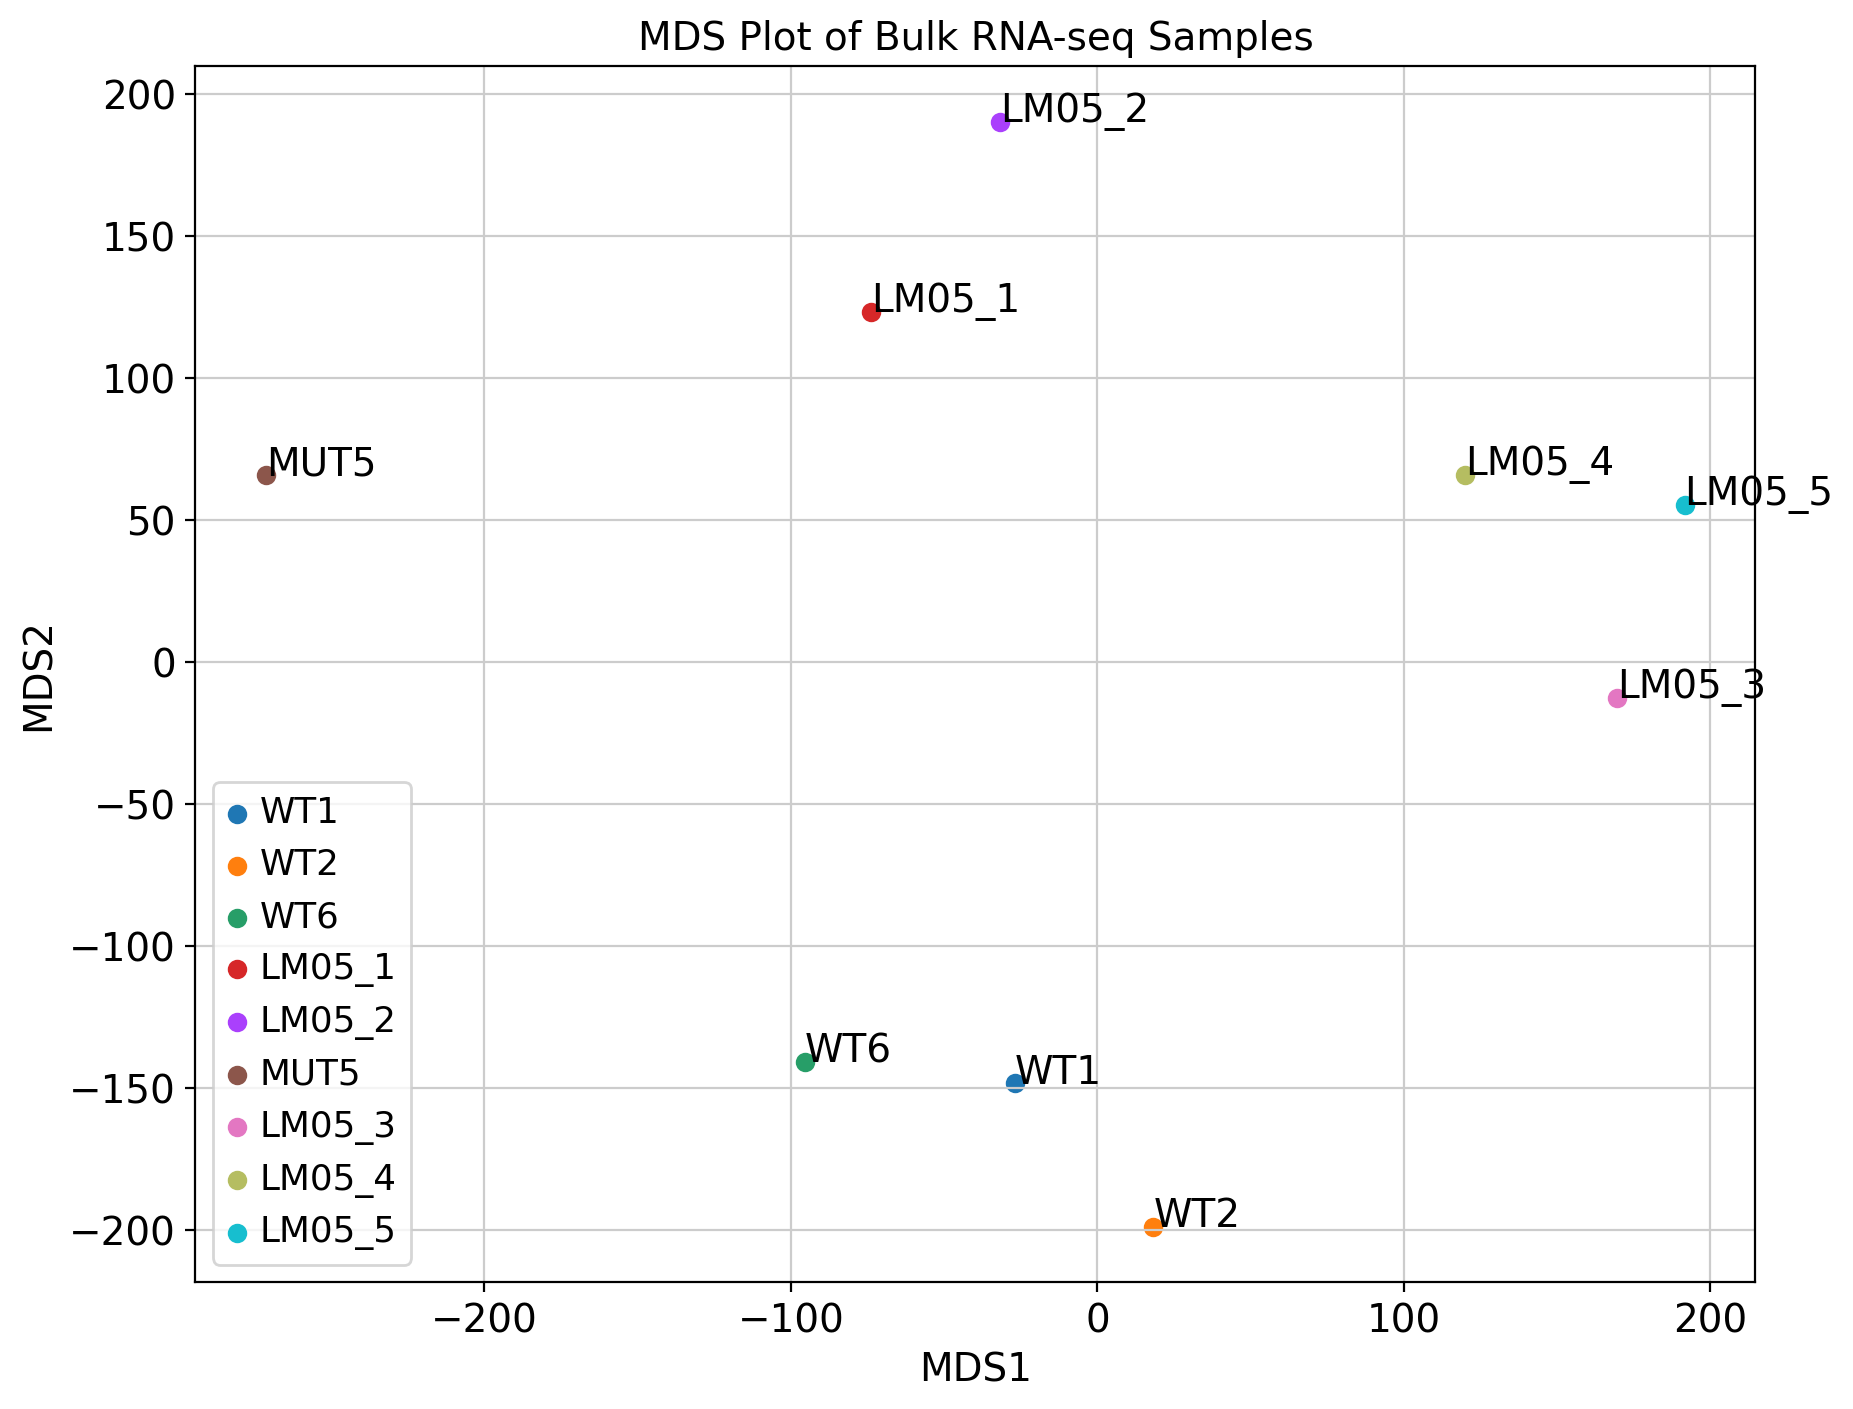

In [35]:
# Transform to logCPM
bulk_df_logcpm = np.log2(bulk_df_norm + 1)

# Create MDS plot
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Transpose the dataframe so that samples are rows
X = bulk_df_logcpm.T

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_scaled)

# Create a DataFrame with MDS results
mds_df = pd.DataFrame(data=X_mds, columns=['MDS1', 'MDS2'], index=X.index)

# Plot
plt.figure(figsize=(10, 8))
for sample in mds_df.index:
    plt.scatter(mds_df.loc[sample, 'MDS1'], mds_df.loc[sample, 'MDS2'], label=sample)
    plt.annotate(sample, (mds_df.loc[sample, 'MDS1'], mds_df.loc[sample, 'MDS2']))

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS Plot of Bulk RNA-seq Samples')
plt.legend()
plt.show()